In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.shape

(1338, 7)

In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Preparing the Data

In [7]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### There are not missing values

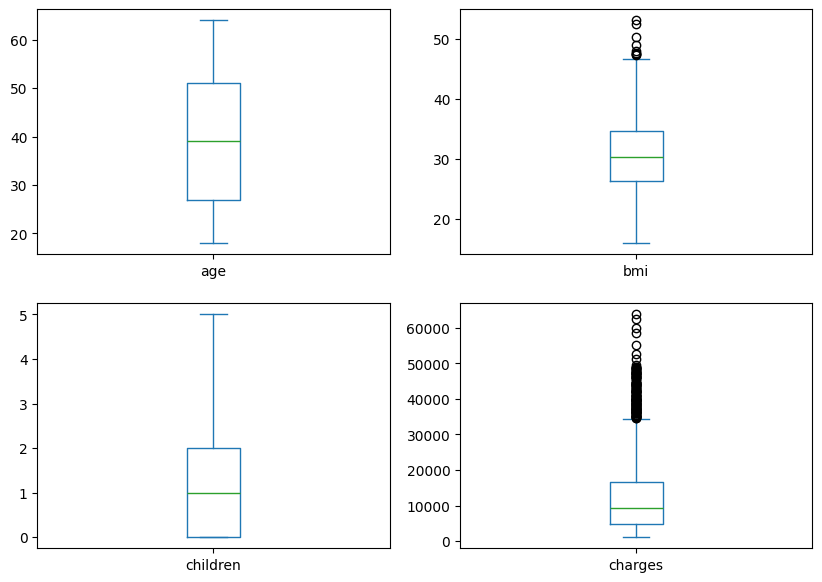

In [8]:
df_to_plot = df[['age', 'bmi', 'children', 'charges']]
df_to_plot.plot(subplots=True, kind='box', layout=(2,2), figsize=(10,7),)
plt.draw()

#### There are outliers but if remove the outliers performance of models get worse

In [9]:
df = pd.get_dummies(df, drop_first=True)

## Visualization

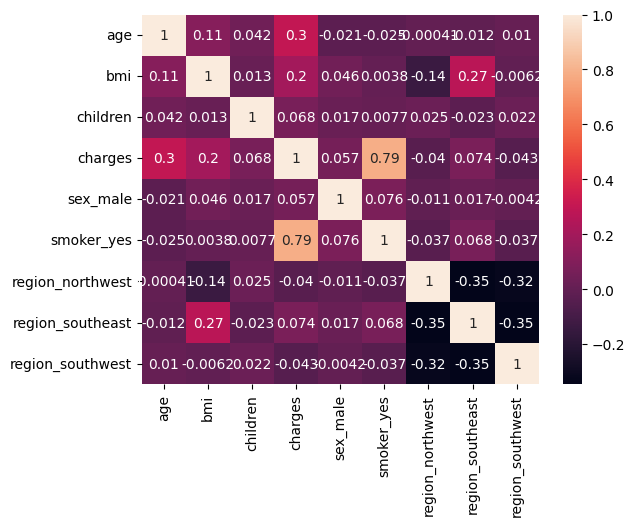

In [10]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.draw()

#### Strong correlation with smoker and charges

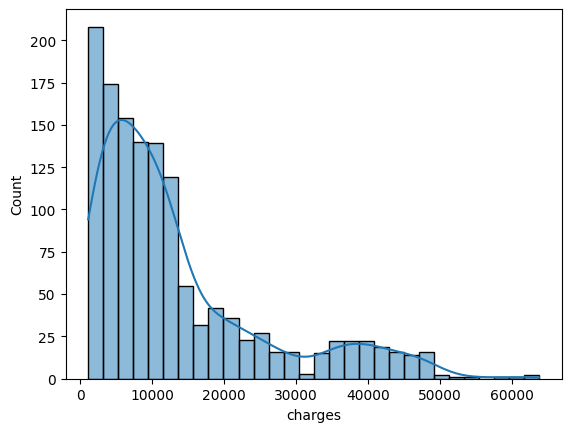

In [11]:
sns.histplot(df.charges, kde=True)
plt.draw()

#### Right skewed charges values

## Preparing the model

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

### Split the data to training and test

In [14]:
x = df.drop('charges', axis=1)
y = df.charges

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [15]:
x.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False


### Linear and regularization regression

In [16]:
lr = LinearRegression().fit(X_train, y_train)
print('Linear Regression')
lr.score(X_test, y_test)

Linear Regression


0.7958786376014414

In [17]:
lasso = Lasso().fit(X_train, y_train)
print('Lasso')
print(lasso.score(X_test, y_test))

ridge = Ridge().fit(X_train, y_train)
print('Ridge')
print(ridge.score(X_test, y_test))

Lasso
0.7958638444221683
Ridge
0.7956166559085319


In [18]:
poly = PolynomialFeatures(degree=2)
X_square_train = poly.fit_transform(X_train)
poly = PolynomialFeatures(degree=2)
X_square_test = poly.fit_transform(X_test)

lr = LinearRegression().fit(X_square_train, y_train)
print('Polynomial')
lr.score(X_square_test, y_test)

Polynomial


0.884186506011592

In [19]:
from sklearn.svm import SVR
svr = SVR(kernel="linear").fit(X_train, y_train)
print('SVR')
svr.score(X_test, y_test)

SVR


-0.09495835013583576

In [20]:
rf = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
print('Random Forest')
rf.score(X_test, y_test)

Random Forest


0.8746016215514123

### Optimization

In [21]:
print('Scores before optimization')
print(cross_val_score(LinearRegression(), X_square_train, y_train, cv=5).mean())
print(cross_val_score(RandomForestRegressor(), X_train, y_train, cv=5).mean())

Scores before optimization
0.8103386539259712
0.8029560307614177


In [22]:
param_grids = {
    "linear": {
        "model": LinearRegression(),
        "params": {
            "fit_intercept": [True, False]
        }
    },
    "svr": {
        "model": SVR(),
        "params": {
        "kernel": ["rbf", "linear"],
        "C": [1, 2, 3, 4, 5]          
        }
    },
    "randomforest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [10, 100, 1000, 50, 200]
        }
    } 
}

scores = []
for k, v in param_grids.items():
    cv = GridSearchCV(v["model"], v["params"], cv=5, return_train_score=False)
    cv.fit(x, y)
    scores.append({"model":k, "best_score": cv.best_score_, "best_params": cv.best_params_})

In [23]:
cv_df = pd.DataFrame(scores)
cv_df

,model,best_score,best_params
0,linear,0.746862,{'fit_intercept': True}
1,svr,-0.077670,"{'C': 5, 'kernel': 'linear'}"
2,randomforest,0.837009,{'n_estimators': 1000}


In [24]:
print('Scores after optimization')
print(cross_val_score(LinearRegression(), X_square_train, y_train, cv=5).mean())
print(cross_val_score(RandomForestRegressor(n_estimators=1000), X_train, y_train, cv=5).mean())

Scores after optimization
0.8103386539259712
0.8038481046504818


In [25]:
def predict_medical_cost(age, bmi, children, ismale, issmoker, region):
    loc_index = np.where(x.columns == f"region_{region}")[0][0]
    inputs = np.zeros(len(x.columns))
    inputs[0], inputs[1], inputs[2], inputs[3], inputs[4] = age, bmi, children, ismale, issmoker
    if loc_index >= 0:
        inputs[loc_index] = 1

    x_poly = PolynomialFeatures(degree=2).fit_transform([inputs])
    return lr.predict(x_poly)[0]

In [26]:
predict_medical_cost(20, 45, 5, 1, 1, "northwest")

51047.19456812182

## Export the model and columns

In [27]:
import joblib
joblib.dump(lr, "saved_model.pkl")

['saved_model.pkl']

In [28]:
import json
columns = {
    'data_columns': [col.lower() for col in x.columns]
}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))